# Modelo VEC vs Modelo MCO

In [95]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from Codigo import *
import seaborn as sn
from statsmodels.stats.diagnostic import normal_ad
sn.set(style="whitegrid")

## 1.- Presentación de los datos y lógica

- Este modelo intenta estimar los datos de el credito al sector privado a traves del nivel de ahorro interno bruto y las reservas legales, obviamente estos dos valores tienen cierto sentido entre ellos y de igual forma afectan al nivel de crédito en la economia.
    - El aumento de los recursos destinandos al prestamo reduciria las tasas de interes aumentando su demanda tanto en el sector de consumo como en el productivo.

## Cargar Datos

In [96]:
Datos = pd.read_excel('../Db.xlsx', sheet_name= 'VARIABLES DEL EXAMEN')
Datos = Datos.T 
Datos.columns = Datos.iloc[1]
Datos = Datos[2:] 
Datos.index = pd.date_range(start='1961-12-31', periods=len(Datos), freq='Y') 
Datos = Datos.astype(float)

In [97]:
Columnas(Datos,'int')

Ahorro interno bruto (US$ a precios actuales)
Ajuste de los términos de intercambio (UMN a precios constantes)
Crédito interno al sector privado otorgado por los bancos (% del PIB)
Crédito interno neto (UMN a precios actuales)
Ingreso interno bruto (UMN a precios constantes)
Recursos de agua dulce  internos renovables per cápita (metros cúbicos)
Recursos de agua dulce  internos renovables, total (billones de metros cúbicos)


In [98]:
data = Datos.copy()
data = data[['Total de reservas (incluye oro, US$ a precios actuales)','Ahorro interno bruto (US$ a precios actuales)','Crédito interno al sector privado otorgado por los bancos (% del PIB)']]
data.columns = ['Reservas','SIB','Credito Bancario'] # Asi nombrare a estas tres variables con fines practicos
print(data.tail(10))

                Reservas           SIB  Credito Bancario
2012-12-31  1.392429e+10  7.328151e+09         38.963868
2013-12-31  1.442907e+10  7.962776e+09         40.926948
2014-12-31  1.512928e+10  7.376464e+09         43.746744
2015-12-31  1.304962e+10  4.648086e+09         51.446939
2016-12-31  1.005363e+10  4.626969e+09         57.406520
2017-12-31  1.024597e+10  5.747795e+09         58.615652
2018-12-31  8.929614e+09  6.230073e+09         62.626342
2019-12-31  6.455450e+09  5.484974e+09         65.838206
2020-12-31  5.247235e+09  3.963366e+09         80.165695
2021-12-31  4.730169e+09  5.440652e+09         75.989137


In [99]:
print(data.describe())
print('La descripcion de los datos me dice que credito bancario se encuentra medido en miles de millones supuestamente')

           Reservas           SIB  Credito Bancario
count  6.100000e+01  6.100000e+01         61.000000
mean   2.827978e+09  1.764625e+09         31.201959
std    4.326311e+09  2.219820e+09         21.064940
min    4.005990e+06  1.750842e+07          2.224959
25%    2.522723e+08  4.026487e+08         12.825620
50%    5.625699e+08  7.638013e+08         28.660167
75%    3.193983e+09  2.619141e+09         48.201845
max    1.512928e+10  7.962776e+09         80.165695
La descripcion de los datos me dice que credito bancario se encuentra medido en miles de millones supuestamente


### Analisis de Estacionariedad a las Variables

In [100]:
DFuller(data['Reservas'])
DFuller(data['SIB'])
DFuller(data['Credito Bancario'])
print('===========================')
print('     RESULTADO       ')
print('===========================')
print('Los resultados indican que los valores no son estacionarios en ninguno de los 3 casos dando valores altisimos')


Estadístico ADF: 1.585597437126751
Valor p: 0.9978137170762671
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: 3.0879599055259654
Valor p: 1.0
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -0.44548971531253956
Valor p: 0.9022221076701307
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
     RESULTADO       
Los resultados indican que los valores no son estacionarios en ninguno de los 3 casos dando valores altisimos


### Analisis de Cointegración

In [101]:

lag_order = select_order(data, maxlags= 10, deterministic= 'n', seasons= 0)

print(lag_order)
print('Selecionamos el que entre ellos tenga mas repetición y sea el menor por parsimonia')

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 10, BIC -> 8, FPE -> 8, HQIC ->  10>
Selecionamos el que entre ellos tenga mas repetición y sea el menor por parsimonia


In [102]:
print('Al 99% de confianza')
Johansen_Test(data,1,8,2)

Al 99% de confianza
Matriz de Valores Criticos vs Maximo Valor Propio
            cvm     eigv        Hipotesis
r = 0     2.7055    43.4435    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    21.1428    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    8.3604    Se rechaza r = 2, existe mas de 2 relación/nes de cointegración
Tabla de Valores Criticos vs Traza Estadistica
            cvt     TS          Hipotesis
r = 0     2.7055    72.9466    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    29.5032    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    8.3604    Se rechaza r = 2, existe mas de 2 relación/nes de cointegración


- Al 99% de nivel de confianza nos dice que todos los datos se cointegran aun que el valor de r = 2 es bastante cercano puede que se requiera no usarlo, de todas formas no da a entender que las 3 variables tienen un alto nivel de integracion a largo plazo esto se puede deber que las 3 variables son indicadores activos del ahorro y prestamo, los cuales estan estrechamente relacionados.
- La estacionariedad nos dicto que ninguno de ellos lo era, asi que podemos definir que el modelo esta completo.

## Modelo Inicial VEC

Para seleccionar el orden el sistema nos dice que para aic y hqic es 10 por lo que usaremos ese 

In [103]:
model = VECM(data ,coint_rank= 2, k_ar_diff= 8)
result = model.fit()
alpha_matrix = result.alpha
print("Matriz de Coeficientes de Corrección de Errores (alpha):")
print(alpha_matrix)


Matriz de Coeficientes de Corrección de Errores (alpha):
[[ 1.76204636e-01 -6.73342531e-02]
 [ 3.83895058e-01 -4.30864976e-01]
 [-2.75367921e-09  6.00491709e-09]]


In [104]:
print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Reservas
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.Reservas            -0.0996      0.185     -0.540      0.590      -0.462       0.262
L1.SIB                  0.7442      0.249      2.987      0.003       0.256       1.233
L1.Credito Bancario -1.075e+07   1.31e+07     -0.822      0.411   -3.64e+07    1.49e+07
L2.Reservas            -0.6460      0.199     -3.240      0.001      -1.037      -0.255
L2.SIB                  0.3028      0.272      1.113      0.266      -0.230       0.836
L2.Credito Bancario -2.313e+07   1.09e+07     -2.117      0.034   -4.45e+07   -1.71e+06
L3.Reservas             0.0757      0.188      0.402      0.687      -0.293       0.445
L3.SIB                  0.7064      0.286      2.467      0.014       0.145       1.268
L3.Credito Bancario -7.293e+06  

$$
\text{{Reservas}}_{t} =  - 0.0996Reservas_{t-1}+ 0.7442SIB_{t-1} - 1.075e+07CB_{t-1} ....
$$


- En el sistema al usar el determinado 'n' eliges no usar el año actual para el pronostico, me parece mas coherente para la realidad por que normalmente se tienen los valores del t-1 en los 3 casos al mismo tiempo ya que son indicadores y contabilidad que se lleva al final del año

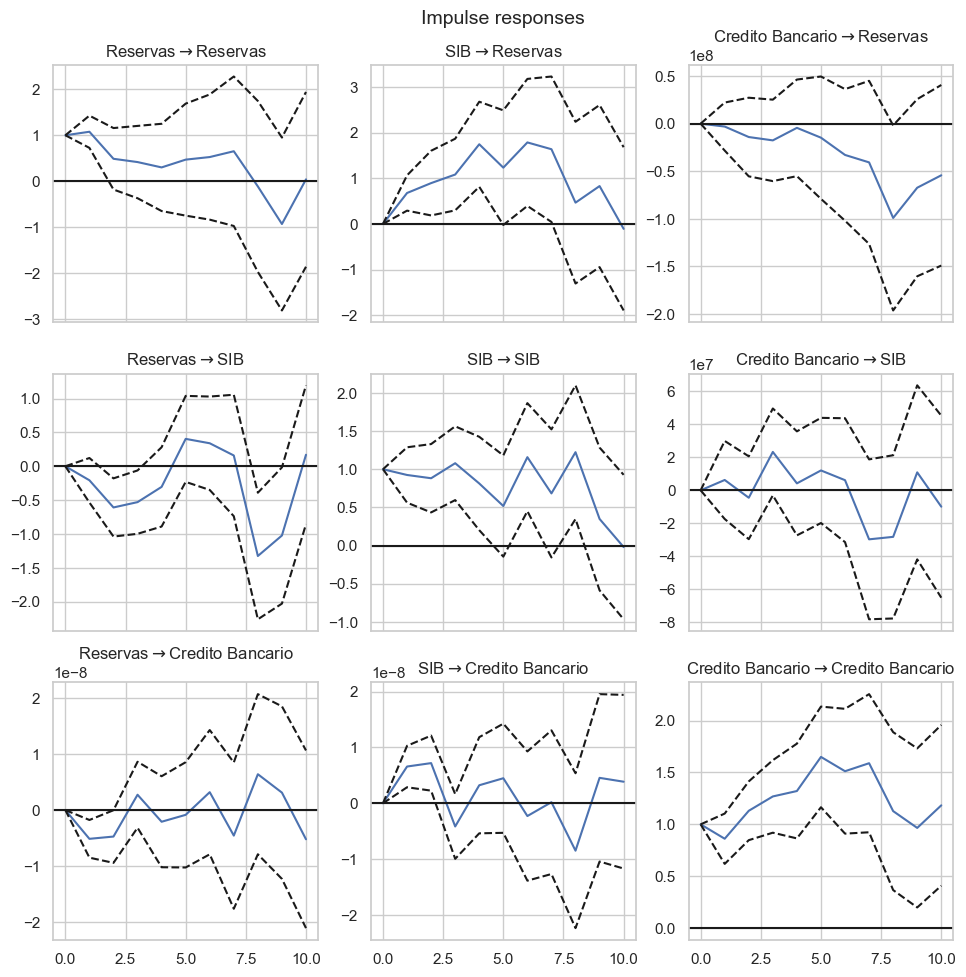

In [105]:
# Paso 6: Análisis de Impulsos-Respuestas
irf = result.irf(periods=10)
irf.plot()
plt.show()

Todos a largo plazo parecen tender al 0 lo que explica que el modelo esta cumpliendo sus propios condicionamientos y no revela un comportamiento caótico, esto es una buena señal de que los parámetros establecidos han sido los adecuados.

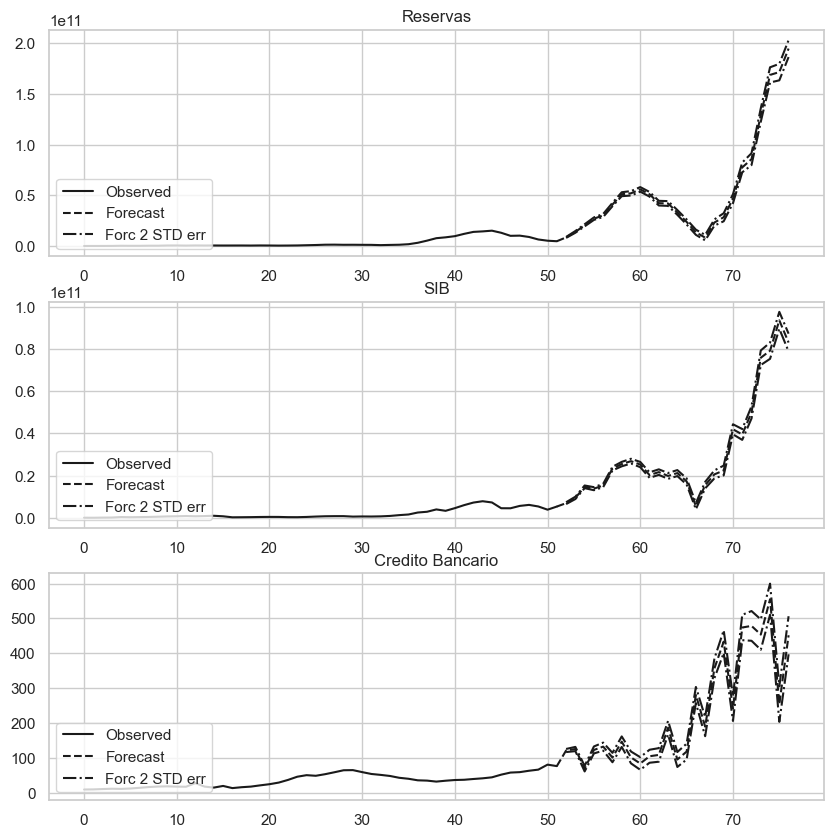

In [106]:
result.plot_forecast(steps = 25)

A pesar de eso la predicción del comportamiento de las reservas y el ahorro interno bruto parecen poco realistas para los proximos años creo que seria bueno agregar otras variables de coyuntura política. Fuera de eso en los primeros 10 años parece tener un comportamiento ciclico que seria interesante revisar

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


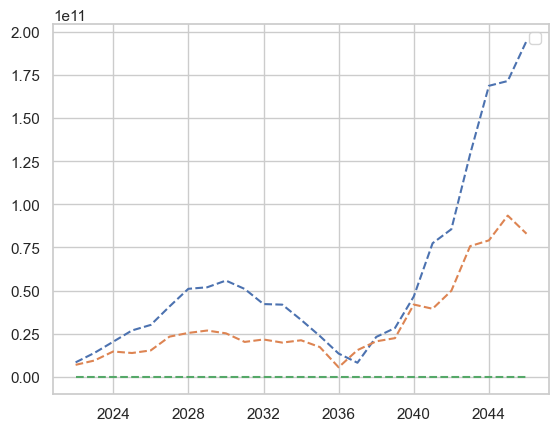

In [107]:
steps = 25
forecast, lower, upper = result.predict(steps, 0.05)
Fecha = pd.date_range(start=data.index[-1], periods=steps, freq='Y')
for i in range(len(data.columns)):
    t_pred = forecast[:,i]
    plt.plot(Fecha, t_pred, linestyle = '--')
plt.legend()
plt.show()

En este Grafico de la relacion no podemos ver la magnitud de Credito Bancario dado que esta en valores con un maximo de 8e+1 y los otros 1e+12

In [108]:

# Obtén los residuos
residuals = result.resid

# Realiza una prueba de normalidad de los residuos (por ejemplo, prueba Anderson-Darling)
ad_statistic, critical_values = normal_ad(residuals)

# Compara el estadístico con los valores críticos
for i in range(len(ad_statistic)):
    print(f'Anderson-Darling statistic: {ad_statistic[i]}, Critical value: {critical_values[i]}') # type: ignore

    # Compara el estadístico con el valor crítico
    if ad_statistic[i] > critical_values[i]: # type: ignore
        print(f'Se rechaza la hipótesis nula de normalidad para el estadístico {i + 1}.')
    else:
        print(f'No hay suficiente evidencia para rechazar la hipótesis nula de normalidad para el estadístico {i + 1}.')

Anderson-Darling statistic: 1.2827134039499057, Critical value: 0.0022217052958445767
Se rechaza la hipótesis nula de normalidad para el estadístico 1.
Anderson-Darling statistic: 0.9509600473018054, Critical value: 0.014983372647439338
Se rechaza la hipótesis nula de normalidad para el estadístico 2.
Anderson-Darling statistic: 0.9379698487272208, Critical value: 0.016147464648889265
Se rechaza la hipótesis nula de normalidad para el estadístico 3.


Ahora sobre la normalidad de los residuos en los 3 casos dio que ninguna sigue el patron de datos especificado que en este caso es normal por lo que concluimos que los residuos no siguen una distribucion normal.

## MCO

Usaremos linlog dado que los datos independientes son bastante grandes y me parece el normalizador adecuado para este.

In [109]:
import statsmodels.api as sm

In [110]:
y = data['Credito Bancario']
x = np.log(data[['Reservas', 'SIB']])

model = sm.OLS(y,x).fit(cov_type='HC3')
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:       Credito Bancario   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              153.0
Date:                Mon, 18 Dec 2023   Prob (F-statistic):                    4.52e-24
Time:                        15:04:52   Log-Likelihood:                         -245.06
No. Observations:                  61   AIC:                                      494.1
Df Residuals:                      59   BIC:                                      498.4
Df Model:                           2                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Manteniendo Constante el Ahorro Interno Bruto cuando las Reservas crecen en una unidad crea un efecto porcentual 430.95% de este en Y, pero cuando mantengo constante las reservas el Ahorro interno bruto crea una disminucion del 419% del valor, lo que me da a entender que pueden estar inversamente correlacionadas y por lo tanto afectado al modelo por ambos lados

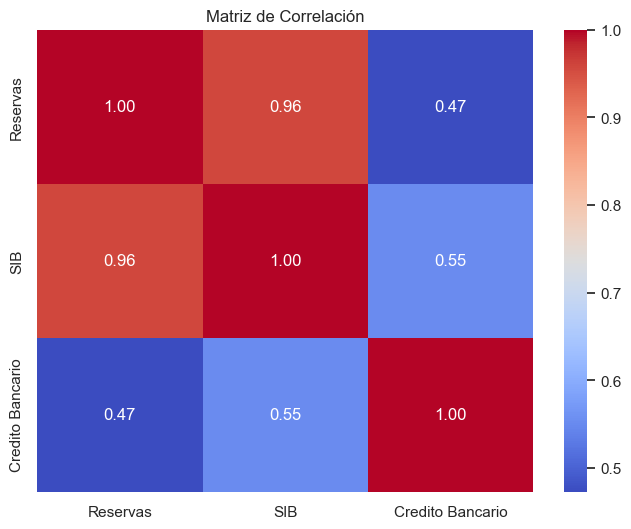

In [111]:

correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


Como se puede ver aqui estan altamente correlacionadas, eso tambien explica por que ambas se explican tan bien entre si en el modelo VEC y crean una dificultad de interpretacion en el modelo MCO lo recomendable para el modelo MCO seria hacer una combinancion de estas.

In [112]:
y = data['Credito Bancario']
x = data['Reservas'] / data['SIB']

model = sm.OLS(y,x).fit(cov_type='HC3')
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:       Credito Bancario   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.822
Method:                 Least Squares   F-statistic:                              172.7
Date:                Mon, 18 Dec 2023   Prob (F-statistic):                    2.60e-19
Time:                        15:04:52   Log-Likelihood:                         -254.51
No. Observations:                  61   AIC:                                      511.0
Df Residuals:                      60   BIC:                                      513.1
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

X1 se podria considerar como un $\frac{Ratio Reservas}{Ahorro interno Bruto}$ y señalar que en esta no existe logaritmo asi que la explicacion seria por cada unidad del ratio anteriormente presentado, al ser porcentual la unidad recomendable seria 0.01, 0.27 unidades de Credito Bancario el cual no sabemos en que escala esta, aumentaria

### Comparativa

Me parece que como metodo de estimación mas simple es el VEC dado que los resultados estimables son mas faciles de hallar, el MCO por si mismo en una serie temporal carece de posiblidades de predecir las acciones generales requeriria un proceso arima para cada variable ya sea en el caso 1 o el caso 2.
Por otro lado el MCO es mucho mas versatil en cuestión de entender las relaciones entre las variables y otorga un mayor entendimiento de estas, sin duda sugiero llevar ambos modelos para relacionar los resultados y el entendimiento del comportamiento que se busca medir.

La información estadistica se encuentra explicada y analizada en cada parte hecha tanto ADFuller, Coeintegracion, Orden de Seleción, Normalidad de los Residuos y otros